In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import pylab as pl

import warnings #to ignore warnings
warnings.filterwarnings('ignore')

In [153]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

# 1. Finding Similar Costumers

## 1.1 Set up the data

In [272]:
data=pd.read_csv('/Users/the_redd_/Desktop/ADM/HW4/bank_transactions.csv')

In [273]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.00
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.00
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.00
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.00


For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.

## Examining the content of the dataset

## Setting dtype up

In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


As we can see, *CustomerDOB*, *TransactionDate* and *TransactionTime* are object in this dataframe, let's handle it. 

In [275]:
#Let's convert TransactionDate to datetime, in order to get a date
data.TransactionDate = pd.to_datetime(data.TransactionDate) 

#Let's convert TransactionTime to datetime, in order to get the time 
def convert_time(value):
    sec = value % 100
    minutes = (value//100)%100
    hours = (value//10000)%100
    date = str(hours)+":"+str(minutes)+":"+str(sec)
    datetime_object = datetime.strptime(date,'%H:%M:%S').time()
    return datetime_object

#Let's apply the function
data['TransactionTime']=data.TransactionTime.apply(lambda row: convert_time(row))

# dt.normalize() basically sets all time component to 00:00:00, and it will only 
# display the date while keeping the datetime64 data format, thereby making it possible to do calculations with it.

data['TransactionTime']=pd.to_datetime(data['TransactionTime'], format='%H:%M:%S') - pd.to_datetime(data['TransactionTime'], format='%H:%M:%S').dt.normalize()

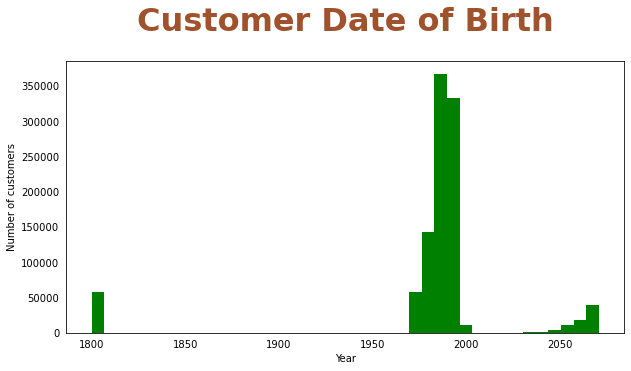

In [276]:
#Now let's handle CustomerDOB
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) # fix date of birth

#Then let's visualize our data
plt.figure(figsize=(10,5))
pl.title("Customer Date of Birth",fontsize=32,fontweight='bold',color='sienna',pad=30)
pl.xlabel("Year")
pl.ylabel("Number of customers")
plt.hist(data.CustomerDOB.dt.year,bins=40,color="green")
plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

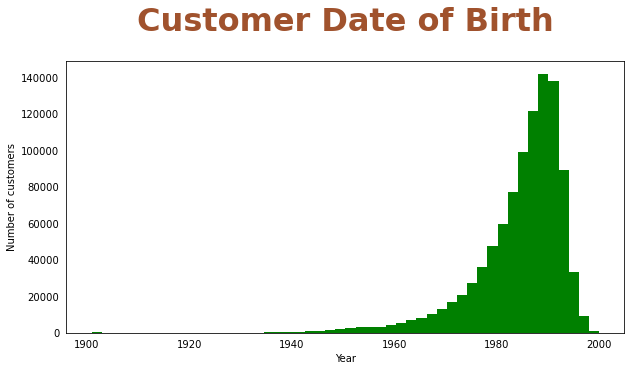

In [277]:
#There are some problems here, since the dataset is from 2016, we suppose valid only date of birth before 2000 and
# possibly, after 1900.

# Let's subtract 100 years to customers whose dob is above 2000
data.loc[data.CustomerDOB.dt.year >2000, 'CustomerDOB'] =  data.loc[data.CustomerDOB.dt.year >2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

# Then let's drop data from customers whose dob is 1800
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0,inplace=True) 

#Let's visualize the result
plt.figure(figsize=(10,5))
pl.title("Customer Date of Birth",fontsize=32,fontweight='bold',color='sienna',pad=30)
pl.xlabel("Year")
pl.ylabel("Number of customers")
plt.hist(data.CustomerDOB.dt.year,bins=50,color="green")
plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

In [278]:
#Let's use the CustomerDOB in order to create a new feature, the age of costumer
data['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)

#Now let's drop all Nan so we can convert into integers
data.dropna(subset=['CustomerAge'],inplace=True)

#Then we convert them
data['CustomerAge'] = data['CustomerAge'].astype(int)

# Then let's drop data from customers age is greater than 100
data.drop(data[data.CustomerAge > 100].index, axis=0,inplace=True) 

In [279]:
# Perfect, now we have all the dtype ready to be used
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987117 entries, 0 to 1048566
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   TransactionID            987117 non-null  object         
 1   CustomerID               987117 non-null  object         
 2   CustomerDOB              987117 non-null  datetime64[ns] 
 3   CustGender               986966 non-null  object         
 4   CustLocation             986966 non-null  object         
 5   CustAccountBalance       984970 non-null  float64        
 6   TransactionDate          987117 non-null  datetime64[ns] 
 7   TransactionTime          987117 non-null  timedelta64[ns]
 8   TransactionAmount (INR)  987117 non-null  float64        
 9   CustomerAge              987117 non-null  int64          
dtypes: datetime64[ns](2), float64(2), int64(1), object(4), timedelta64[ns](1)
memory usage: 82.8+ MB


### Dealing with NAN values

In [280]:
#Let's see if there are any Nan in the dataset
data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                   0
CustGender                  151
CustLocation                151
CustAccountBalance         2147
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
CustomerAge                   0
dtype: int64

In [281]:
for col in data.columns:
    print("Percentage of null values of {}:".format(col),str(np.round(data[col].isna().sum()/len(data)*100,2)) + '%')

Percentage of null values of TransactionID: 0.0%
Percentage of null values of CustomerID: 0.0%
Percentage of null values of CustomerDOB: 0.0%
Percentage of null values of CustGender: 0.02%
Percentage of null values of CustLocation: 0.02%
Percentage of null values of CustAccountBalance: 0.22%
Percentage of null values of TransactionDate: 0.0%
Percentage of null values of TransactionTime: 0.0%
Percentage of null values of TransactionAmount (INR): 0.0%
Percentage of null values of CustomerAge: 0.0%


In [282]:
# Since the percentage of Nan values in CustGender and CustLocation is smaller than 0.03%, we decide to drop them.

data.dropna(subset=['CustGender','CustLocation'], inplace = True)

#Taking into account CustAccountBalance, we can fill all the Nan values with the mean computed for every location and drop all the Nan values with no location

data.CustAccountBalance = data.CustAccountBalance.fillna(data.groupby('CustLocation')['CustAccountBalance'].transform('mean'))

data.dropna(subset=['CustAccountBalance'], inplace = True)

In [283]:
data.isnull().sum() #Better

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
CustomerAge                0
dtype: int64

### Checking columns

In [284]:
#Let's drop TransactionID since it is quite useless in our analysis
data.drop(['TransactionID'],axis=1,inplace=True)

In [285]:
#Then let's check CustGender
data['CustGender'].value_counts()

M    713387
F    273270
Name: CustGender, dtype: int64

In [286]:
#Let's rename TransactionAmount (INR) in TransactionAmount just for semplicity
data.rename(columns={'TransactionAmount (INR)':'TransactionAmount'},inplace=True)
data.head(1)

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,CustomerAge
0,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,0 days 14:32:07,25.00,28


In [287]:
#Let's create some new features like TransactionMonth, TransactionMonthName and TransactionDayName
data['TransactionMonth'] = data.TransactionDate.dt.month
data['TransactionMonthName'] = data.TransactionDate.dt.month_name()

data['TransactionDay'] = data.TransactionDate.dt.day
data['TransactionDayName'] = data.TransactionDate.dt.day_name()

data.drop('TransactionDate',axis=1,inplace=True) #we needed it only to get TransactionDayName

## Exploratory Data Analysis(EDA)

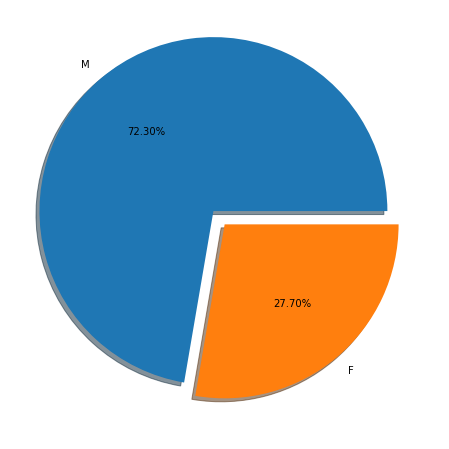

In [288]:
labels = data.CustGender.value_counts().keys()
values = data.CustGender.value_counts().values
explode = (0.1,0)

plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.2f%%');

A significant proportion of bank customers are males accounting for about 72% of the total share.

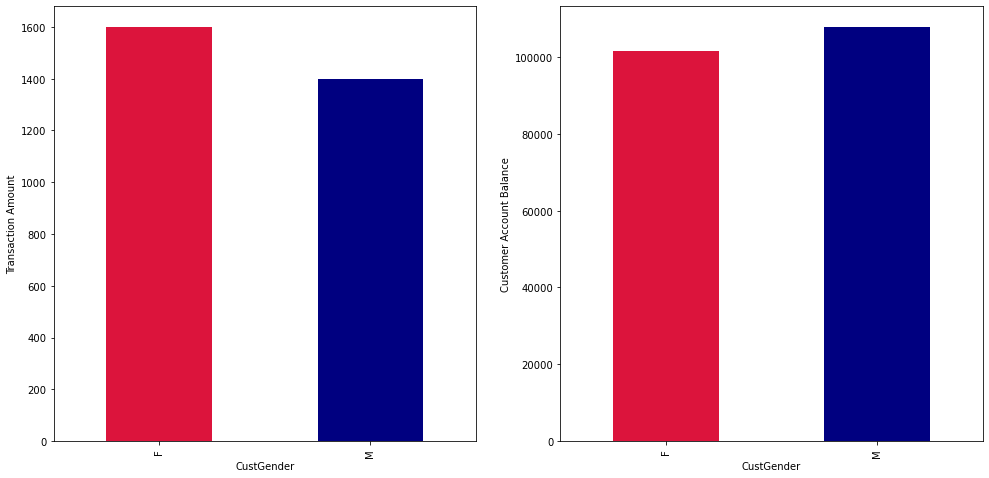

In [289]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplot(1, 2, 1)
ax1 = data.groupby('CustGender')['TransactionAmount'].mean().plot(kind='bar',color=['crimson','navy'])
plt.ylabel('Transaction Amount')

plt.subplot(1, 2, 2)
ax2 = data.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',color=['crimson','navy'])
plt.ylabel('Customer Account Balance')
plt.subplots_adjust(right=1.2)
plt.show()

As we can see, male customers have, on average, marginally higher **account balances** in comparison to their female counterparts. On the other hand, females make ,on average, slightly higher **transactions** than males.

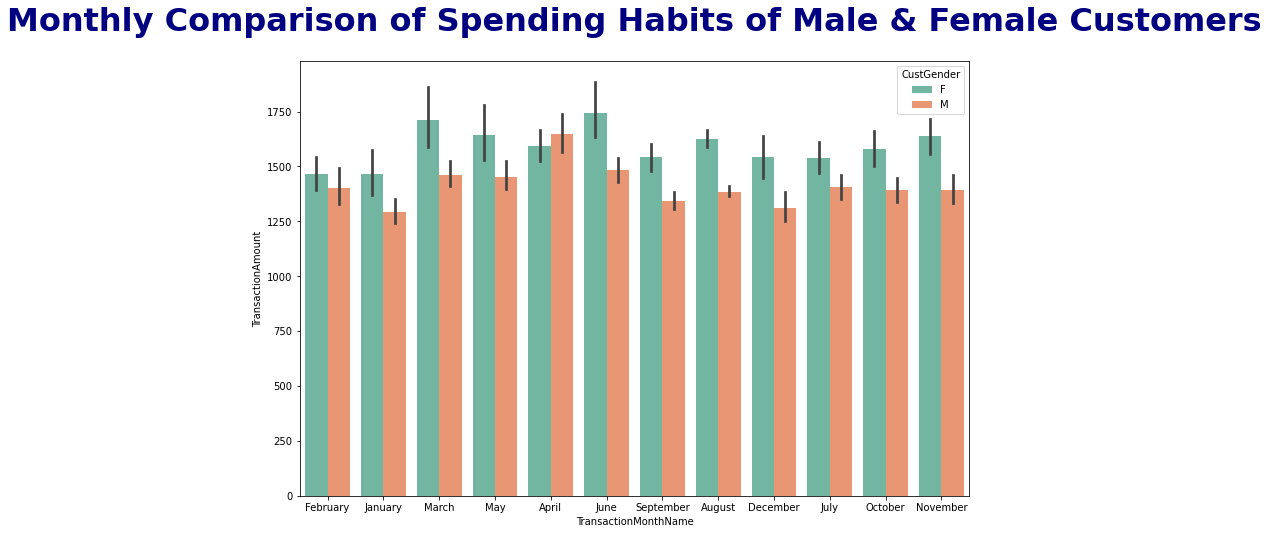

In [290]:
sns.barplot(data=data,x='TransactionMonthName',y='TransactionAmount',palette='Set2',hue='CustGender')
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

Female customers make lower transactions than their male counterparts only during the months of February and April. In all the remaining months, male customers perform a lower amount of transactions. Higher value transactions are mostly done during the months of March, April and June. While the lower transaction are mostly done in January and February.

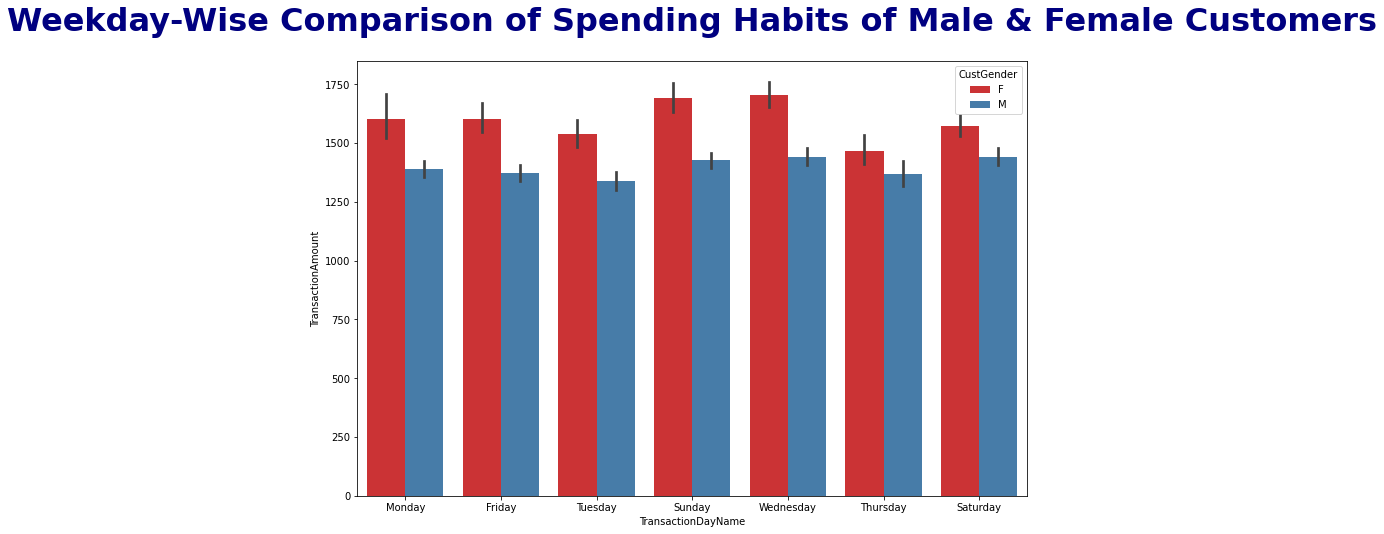

In [269]:
sns.barplot(data=data,x='TransactionDayName',y='TransactionAmount',palette='Set1',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

Female customers perform higher transactions than their male counterparts in almost every week day.

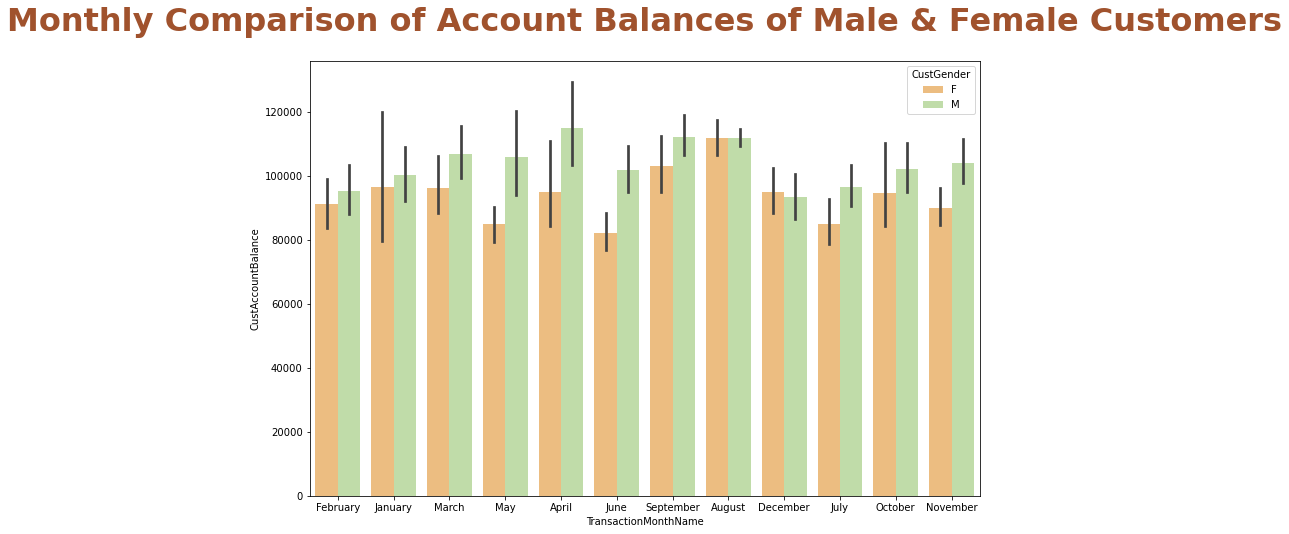

In [270]:
sns.barplot(data=data,x='TransactionMonthName',y='CustAccountBalance',palette='Spectral',hue='CustGender')
plt.title('Monthly Comparison of Account Balances of Male & Female Customers',fontsize=32,fontweight='bold',color='sienna',pad=30);

Male customers generally have greater account balances as compared to their female counterparts. This is evident from the fact that they generally make comparatively low value transactions than female customers. The only month male account balances are equal to female account balances is August.

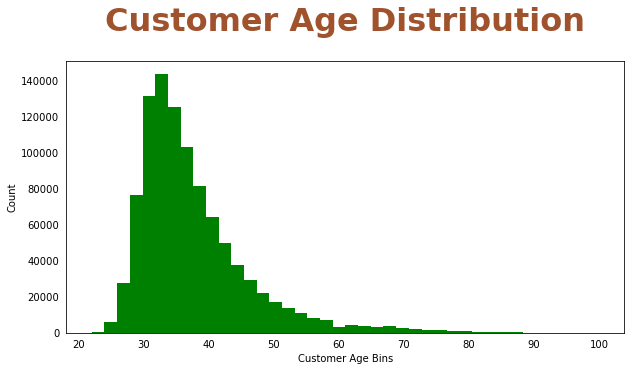

In [271]:
plt.figure(figsize=(10,5))
plt.title("Customer Age Distribution",fontsize=32,fontweight='bold',color='sienna',pad=30)
plt.xlabel("Customer Age Bins")
plt.ylabel("Count")
plt.hist(data.CustomerAge,bins=40,color="green")
plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

We can see how customers with age up to 35 are in majority followed by 35 - 50.